In [ ]:
#!pip install --user --upgrade pip
#!pip install -U setuptools --user
#!pip install tensorflow
#!pip install zipfile38
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install sklearn
#!pip install matplotlib
#!pip install pycaret
#!pip install ipywidgets
#!pip3 install --pre --extra-index-url https://developer.download.nvidia.com/compute/redist/jp/v502 tensorflow==2.10.0+nv22.10
#!pip install protobuf

# Dependencies

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 13 15:26:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    40W / 300W |  15504MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D

import numpy as np
import pandas as pd
import os
import sys

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import sklearn as sk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/lnu-deep-learn-1-image-classification-2023.zip'
%ls

Показано результат, скорочений до останніх рядків (5000).
  inflating: train/IO MOTH/1621ac27a7914f57a08f6627cf6bc537.jpg  
  inflating: train/IO MOTH/16a9744a58a347b9ab1634ae42c677b3.jpg  
  inflating: train/IO MOTH/16e7b92c0fe1499f9eb59e0d939c5612.jpg  
  inflating: train/IO MOTH/1946e40c80db468982edfc0c296c4077.jpg  
  inflating: train/IO MOTH/1980659f10fc4848853065b5ab7d836f.jpg  
  inflating: train/IO MOTH/1ef0332157d34f4f8a9c00b9f5cdbb04.jpg  
  inflating: train/IO MOTH/29344cdb48194136be2da87174b63ecc.jpg  
  inflating: train/IO MOTH/2a813c597b6249b982e8e2b4b28326c4.jpg  
  inflating: train/IO MOTH/2c028c2617294548b5fb1ad9810ff593.jpg  
  inflating: train/IO MOTH/2d734551283d4d9d82cf3cf838ed6214.jpg  
  inflating: train/IO MOTH/2f1ba6c6820c4bedafc12dc8eea03d0c.jpg  
  inflating: train/IO MOTH/31cf6c0108ba4fe9ac645fd65a385b31.jpg  
  inflating: train/IO MOTH/31d4582510e744199bb480c1e4d7adc4.jpg  
  inflating: train/IO MOTH/33c1ad8099ac4f46a74c2421d6b398c4.jpg  
  inflating: train

# Functions

In [ ]:
def plot_augmentation(augmented_data, generator, directory, class_names, n_images = 7):
    batch = augmented_data.next()
    images, labels = batch

    plt.figure(figsize=(10, 5))
    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Original\nClass: {class_names[np.argmax(labels[i])]}", fontsize = 6)
        plt.axis('off')

    augmented_batch = (images, labels)
    augmented_iterator = generator.flow(augmented_batch, batch_size=n_images)

    augmented_images, augmented_labels = augmented_iterator.next()

    for i in range(n_images):
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(image.array_to_img(augmented_images[i]))
        plt.title(f"Augmented\nClass: {class_names[np.argmax(augmented_labels[i])]}", fontsize = 6)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def preprocess_data(X, y):
    # препроцесинг для підготовки формату, необхідного моделі
    X = preprocess_input(X)
    # текст у список ідекс - слово
    y = tf.one_hot(y, 100)
    return X, y

# Data prepocessing


In [ ]:
with open('classes.txt') as f:
    class_names = [line.rstrip() for line in f]
class_names

['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'AMERICAN SNOOT',
 'AN 88',
 'APPOLLO',
 'ARCIGERA FLOWER MOTH',
 'ATALA',
 'ATLAS MOTH',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'BANDED TIGER MOTH',
 'BECKERS WHITE',
 'BIRD CHERRY ERMINE MOTH',
 'BLACK HAIRSTREAK',
 'BLUE MORPHO',
 'BLUE SPOTTED CROW',
 'BROOKES BIRDWING',
 'BROWN ARGUS',
 'BROWN SIPROETA',
 'CABBAGE WHITE',
 'CAIRNS BIRDWING',
 'CHALK HILL BLUE',
 'CHECQUERED SKIPPER',
 'CHESTNUT',
 'CINNABAR MOTH',
 'CLEARWING MOTH',
 'CLEOPATRA',
 'CLODIUS PARNASSIAN',
 'CLOUDED SULPHUR',
 'COMET MOTH',
 'COMMON BANDED AWL',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'CRECENT',
 'CRIMSON PATCH',
 'DANAID EGGFLY',
 'EASTERN COMA',
 'EASTERN DAPPLE WHITE',
 'EASTERN PINE ELFIN',
 'ELBOWED PIERROT',
 'EMPEROR GUM MOTH',
 'GARDEN TIGER MOTH',
 'GIANT LEOPARD MOTH',
 'GLITTERING SAPPHIRE',
 'GOLD BANDED',
 'GREAT EGGFLY',
 'GREAT JAY',
 'GREEN CELLED CATTLEHEART',
 'GREEN HAIRSTREAK',
 'GREY HAIRSTREAK',
 'HERCULES MOTH',
 'HUMMING BIRD H

In [ ]:
img_size = (224, 224)
batch_size = 32
number_of_epochs = 15
learning_rate = 0.0001

image_datagenerator = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 50,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True ,
                    vertical_flip = True ,
                    fill_mode = 'nearest',
                    validation_split = 0.35)


train_generator = image_datagenerator.flow_from_directory(
        'train',
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        subset='training')

validation_generator = image_datagenerator.flow_from_directory(
        'train',
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Found 7139 images belonging to 100 classes.
Found 3772 images belonging to 100 classes.


In [ ]:
steps_per_epoch=train_generator.n/batch_size
validation_steps=validation_generator.n/batch_size

In [ ]:
steps_per_epoch, validation_steps

(223.09375, 117.875)

In [ ]:
(train_dataset,val_dataset)= tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    shuffle = True,
    image_size = img_size ,
    batch_size = 32,
    subset = "both",
    validation_split = 0.35,
    seed = 123
    )

Found 10911 files belonging to 100 classes.
Using 7093 files for training.
Using 3818 files for validation.


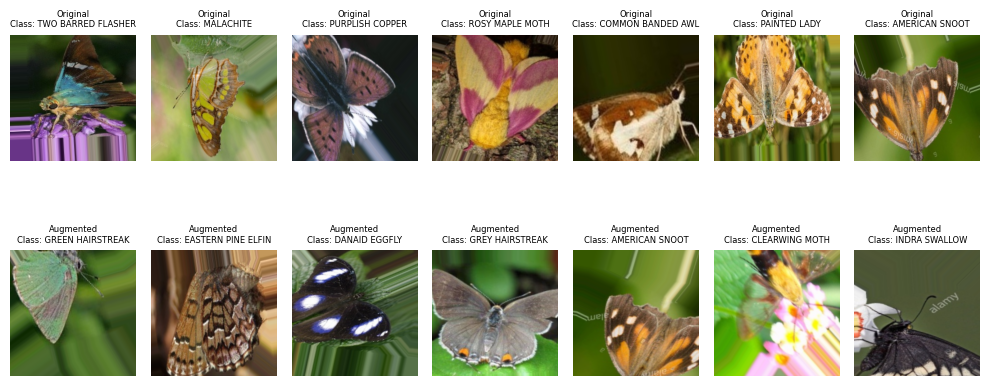

In [ ]:
plot_augmentation(train_generator, image_datagenerator, 'train', class_names)

In [ ]:
data_frame = pd.read_csv('train.csv')
# кількість прикладів у кожному класі
label_numbers = data_frame['label'].value_counts().to_dict()
# представлення назви класу числом - ID
label_dict = {label: idx for idx, label in enumerate(label_numbers.keys())}
label_dict_rev = {new_label: orig_label for orig_label, new_label in label_dict.items()}

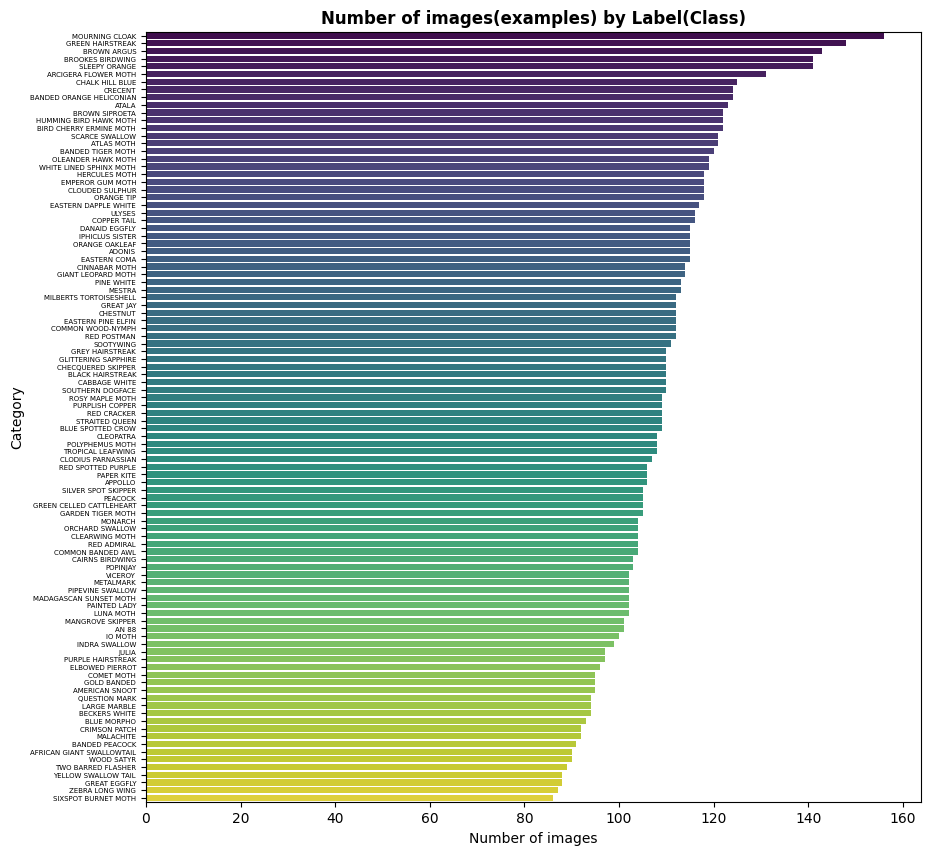

In [ ]:
plt.figure(figsize = (10, 10))

df = pd.DataFrame(list(label_numbers.items()), columns=['Label', 'Number of images'])
sns.barplot(x = 'Number of images', y = 'Label', data=df, palette='viridis')

plt.title('Number of images(examples) by Label(Class)', fontweight='bold')
plt.yticks(fontsize=5)
plt.ylabel("Category");

# Three differnt NN architecture comparison

In [ ]:
base_model = Xception(weights='imagenet',include_top=False,
                      pooling='avg')

base_model.trainable = False

model_seq = models.Sequential()
model_seq.add(base_model)
model_seq.add(layers.Dense(1024, activation='relu'))
model_seq.add(layers.Dropout(0.5))
model_seq.add(layers.Dense(100, activation='softmax'))

model_seq.summary()

model_seq.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 100)               102500    
                                                                 
Total params: 23062156 (87.98 MB)
Trainable params: 2200676 (8.39 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
hist_seq = model_seq.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = number_of_epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      verbose=1
      ).history

Epoch 1/15
223/223 [==============================] - 127s 555ms/step - loss: 3.8264 - accuracy: 0.1813 - val_loss: 2.8711 - val_accuracy: 0.4502
Epoch 2/15
223/223 [==============================] - 122s 548ms/step - loss: 2.5785 - accuracy: 0.4066 - val_loss: 1.9460 - val_accuracy: 0.6137
Epoch 3/15
223/223 [==============================] - 123s 552ms/step - loss: 1.9653 - accuracy: 0.5201 - val_loss: 1.5433 - val_accuracy: 0.6511
Epoch 4/15
223/223 [==============================] - 120s 539ms/step - loss: 1.6389 - accuracy: 0.5826 - val_loss: 1.3093 - val_accuracy: 0.6986
Epoch 5/15
223/223 [==============================] - 122s 549ms/step - loss: 1.4302 - accuracy: 0.6266 - val_loss: 1.1578 - val_accuracy: 0.7288
Epoch 6/15
223/223 [==============================] - 124s 557ms/step - loss: 1.2761 - accuracy: 0.6578 - val_loss: 1.0556 - val_accuracy: 0.7447
Epoch 7/15
223/223 [==============================] - 124s 555ms/step - loss: 1.1911 - accuracy: 0.6795 - val_loss: 0.9767 -

In [ ]:
densenet_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(528, activation='relu')(x)
predictions = layers.Dense(100, activation='softmax')(x)

model_dense = Model(inputs=densenet_model.input, outputs=predictions)
for layer in densenet_model.layers:
    layer.trainable = False

model_dense.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model_dense.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, 230, 230, 3)          0         ['input_10[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_10[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
hist_dense = model_dense.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=number_of_epochs,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      verbose=1
      ).history

Epoch 1/15
223/223 [==============================] - 131s 557ms/step - loss: 2.5300 - acc: 0.3795 - val_loss: 1.1478 - val_acc: 0.6721
Epoch 2/15
223/223 [==============================] - 120s 537ms/step - loss: 1.0784 - acc: 0.6928 - val_loss: 0.8595 - val_acc: 0.7442
Epoch 3/15
223/223 [==============================] - 121s 542ms/step - loss: 0.8047 - acc: 0.7679 - val_loss: 0.6501 - val_acc: 0.8163
Epoch 4/15
223/223 [==============================] - 123s 550ms/step - loss: 0.7222 - acc: 0.7868 - val_loss: 0.8529 - val_acc: 0.7643
Epoch 5/15
223/223 [==============================] - 121s 545ms/step - loss: 0.6390 - acc: 0.8080 - val_loss: 0.6092 - val_acc: 0.8152
Epoch 6/15
223/223 [==============================] - 121s 543ms/step - loss: 0.5889 - acc: 0.8283 - val_loss: 0.6989 - val_acc: 0.8075
Epoch 7/15
223/223 [==============================] - 122s 548ms/step - loss: 0.5539 - acc: 0.8354 - val_loss: 0.5908 - val_acc: 0.8314
Epoch 8/15
223/223 [============================

In [ ]:
resnet_model = ResNet50(include_top=False,weights="imagenet")
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
res = tf.keras.layers.Dense(100, activation="softmax")(x)

model_res = Model(inputs=resnet_model.input, outputs=res)
for layer in resnet_model.layers:
    layer.trainable = False

model_res.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model_res.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
hist_res = model_res.fit(
      train_dataset,
      epochs=number_of_epochs,
      validation_data=val_dataset,
      verbose=1
      ).history

Epoch 1/15
256/256 [==============================] - 19s 58ms/step - loss: 2.3529 - accuracy: 0.4921 - val_loss: 1.1659 - val_accuracy: 0.7191
Epoch 2/15
256/256 [==============================] - 14s 53ms/step - loss: 0.7154 - accuracy: 0.8218 - val_loss: 0.7123 - val_accuracy: 0.8203
Epoch 3/15
256/256 [==============================] - 13s 51ms/step - loss: 0.4113 - accuracy: 0.8960 - val_loss: 0.6069 - val_accuracy: 0.8376
Epoch 4/15
256/256 [==============================] - 13s 52ms/step - loss: 0.2644 - accuracy: 0.9370 - val_loss: 0.5675 - val_accuracy: 0.8471
Epoch 5/15
256/256 [==============================] - 13s 51ms/step - loss: 0.1818 - accuracy: 0.9576 - val_loss: 0.4794 - val_accuracy: 0.8691
Epoch 6/15
256/256 [==============================] - 13s 52ms/step - loss: 0.1270 - accuracy: 0.9717 - val_loss: 0.4771 - val_accuracy: 0.8709
Epoch 7/15
256/256 [==============================] - 13s 52ms/step - loss: 0.0903 - accuracy: 0.9791 - val_loss: 0.4810 - val_accuracy:

# Results

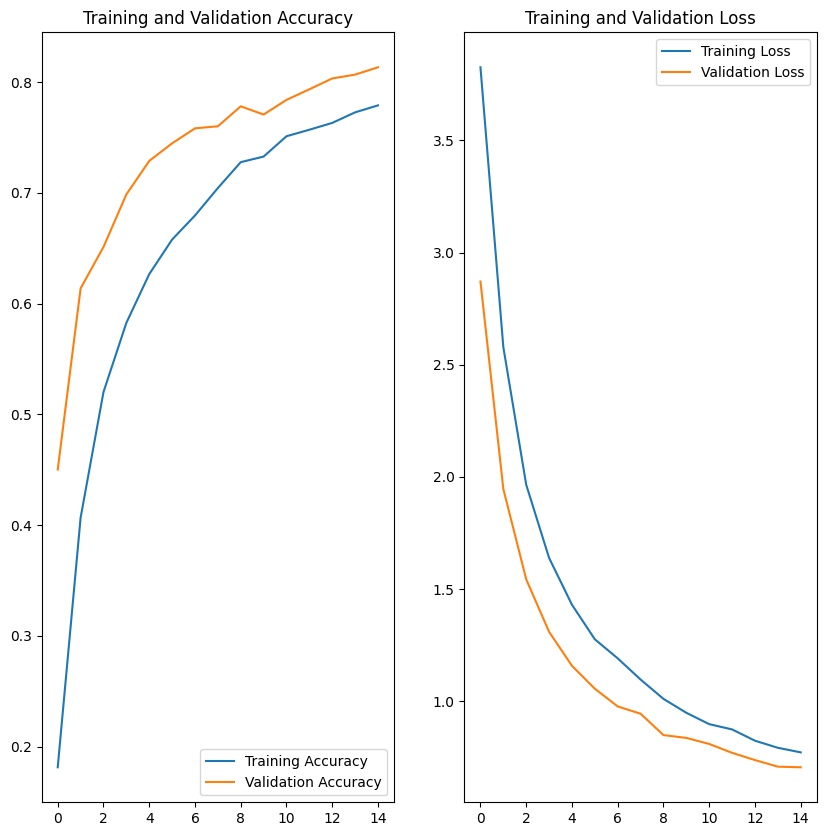

In [ ]:
accuracy_seq = hist_seq['accuracy']
validation_accuracy_seq= hist_seq['val_accuracy']

loss_seq = hist_seq['loss']
validation_loss_seq = hist_seq['val_loss']

plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(number_of_epochs), accuracy_seq, label='Training Accuracy')
plt.plot(range(number_of_epochs), validation_accuracy_seq, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(number_of_epochs), loss_seq, label = 'Training Loss')
plt.plot(range(number_of_epochs), validation_loss_seq, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

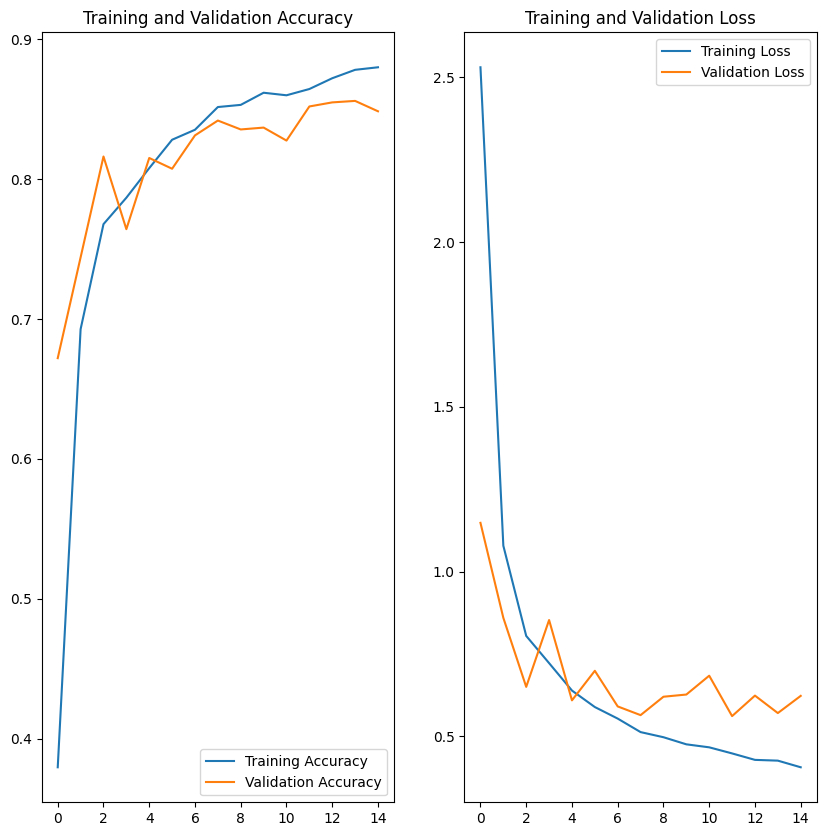

In [ ]:
accuracy_dense = hist_dense['acc']
validation_accuracy_dense= hist_dense['val_acc']

loss_dense = hist_dense['loss']
validation_loss_dense = hist_dense['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(number_of_epochs), accuracy_dense, label='Training Accuracy')
plt.plot(range(number_of_epochs), validation_accuracy_dense, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(number_of_epochs), loss_dense, label='Training Loss')
plt.plot(range(number_of_epochs), validation_loss_dense, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

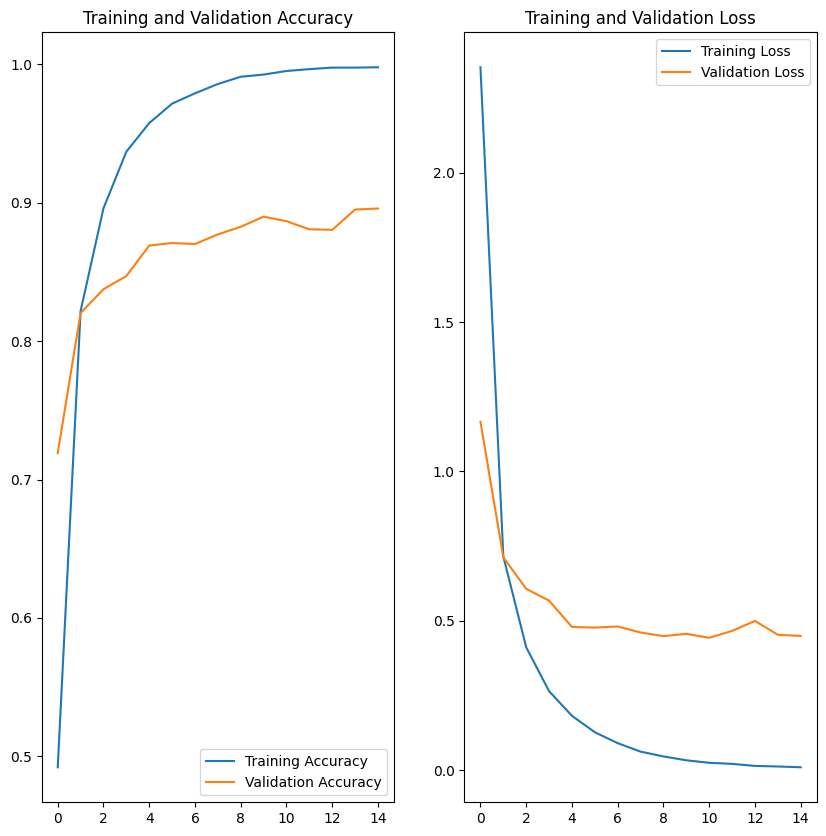

In [ ]:
accuracy_res = hist_res['accuracy']
validation_accuracy_res= hist_res['val_accuracy']

loss_res = hist_res['loss']
validation_loss_res = hist_res['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(number_of_epochs), accuracy_res, label='Training Accuracy')
plt.plot(range(number_of_epochs), validation_accuracy_res, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(number_of_epochs), loss_res, label='Training Loss')
plt.plot(range(number_of_epochs), validation_loss_res, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predictions

In [ ]:
predictions_xception = model_seq.predict(validation_generator)
predictions_densenet = model_dense.predict(val_dataset)
predictions_resnet = model_res.predict(val_dataset)

y_pred_xception = np.argmax(predictions_xception, axis = 1)
y_pred__densenet = np.argmax(predictions_densenet, axis = 1)
y_pred_resnet = np.argmax(predictions_resnet, axis = 1)

y_true_xception = validation_generator.classes

y_true_densenet = np.concatenate([y for x, y in val_dataset], axis=0)
y_true_resnet = np.concatenate([y for x, y in val_dataset], axis=0)

class_report_xception = classification_report(y_true_xception, y_pred_xception, target_names = class_names)
print("Classification Report (Xception):")
print(class_report_xception)

class_report_dense = classification_report(y_true_densenet, y_pred__densenet, target_names = class_names)
print("Classification Report (DenseNet121):")
print(class_report_dense)

class_report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names = class_names)
print("Classification Report (ResNet50):")
print(class_report_resnet)


120/120 [==============================] - 5s 38ms/step
Classification Report (Xception):
                           precision    recall  f1-score   support

                   ADONIS       0.88      0.57      0.70        40
AFRICAN GIANT SWALLOWTAIL       1.00      0.90      0.95        31
           AMERICAN SNOOT       0.83      0.73      0.77        33
                    AN 88       0.97      0.97      0.97        35
                  APPOLLO       0.82      0.76      0.79        37
     ARCIGERA FLOWER MOTH       0.88      0.82      0.85        45
                    ATALA       0.89      0.93      0.91        43
               ATLAS MOTH       0.84      0.90      0.87        42
 BANDED ORANGE HELICONIAN       0.98      0.95      0.96        43
           BANDED PEACOCK       0.87      0.65      0.74        31
        BANDED TIGER MOTH       0.83      0.90      0.86        42
            BECKERS WHITE       0.78      0.78      0.78        32
  BIRD CHERRY ERMINE MOTH       0.95  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plt.figure(figsize=(25, 25))
cm_xception = confusion_matrix(y_true_xception, y_pred_xception)
sns.heatmap(cm_xception, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Xception)')
plt.show()

plt.figure(figsize=(25, 25))
cm_densenet = confusion_matrix(y_true_densenet, y_pred__densenet)
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DenseNet121)')
plt.show()

plt.figure(figsize=(25, 25))
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet50)')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 25ms/step
This image most likely belongs to EMPEROR GUM MOTH 


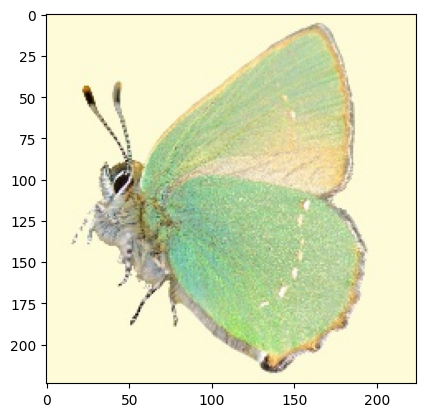

In [ ]:
img = tf.keras.preprocessing.image.load_img('test/0b69013373b04635aba93e9cf3b5f55a.jpg',
                                            target_size = (224, 224))
img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)

score = model_seq.predict(img_array)
print("This image most likely belongs to {} ".format(class_names[np.argmax(score)]))
plt.imshow(img)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to BANDED ORANGE HELICONIAN 


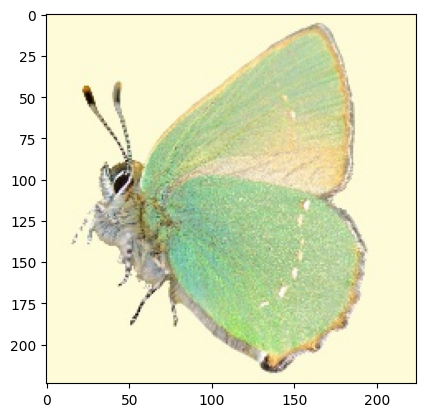

In [ ]:
img = tf.keras.preprocessing.image.load_img('test/0b69013373b04635aba93e9cf3b5f55a.jpg',
                                            target_size = (224, 224))
img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)

score = model_dense.predict(img_array)
print("This image most likely belongs to {} ".format(class_names[np.argmax(score)]))
plt.imshow(img)

1/1 [==============================] - 0s 27ms/step
This image most likely belongs to GREEN HAIRSTREAK 


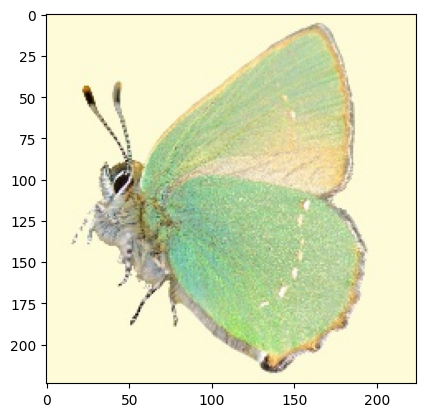

In [ ]:
img = tf.keras.preprocessing.image.load_img('test/0b69013373b04635aba93e9cf3b5f55a.jpg',
                                            target_size = (224, 224))
img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)

score = model_res.predict(img_array)
print("This image most likely belongs to {} ".format(class_names[np.argmax(score)]))
plt.imshow(img)

In [ ]:
test = pd.read_csv('test.csv')
test.head()
paths = test['path']
classes = []
for path in paths:
    img = tf.keras.preprocessing.image.load_img(path,
                                            target_size=(224, 224))
    img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)
    score = model_res.predict(img_array)
    classes.append(class_names[np.argmax(score)])


1/1 [==============================] - 0s 23ms/step


In [ ]:
test

,id,path
0,4cfe706486ee4561a89188090f52b9c6,test/4cfe706486ee4561a89188090f52b9c6.jpg
1,2874a810e78844ccbedfb4ae5e54b88a,test/2874a810e78844ccbedfb4ae5e54b88a.jpg
2,8dd78fedc88644e6baba3642d57049af,test/8dd78fedc88644e6baba3642d57049af.jpg
3,c1022ebd1c564bc88b4515e1f9216ab3,test/c1022ebd1c564bc88b4515e1f9216ab3.jpg
4,19d87765acbd438bbf1b7cec8ff4fe16,test/19d87765acbd438bbf1b7cec8ff4fe16.jpg
...,...,...
2723,4a095351a0ed4fe29633e6ad9913018c,test/4a095351a0ed4fe29633e6ad9913018c.jpg
2724,1d9d58ac55024131a3ccb53c942dd0f1,test/1d9d58ac55024131a3ccb53c942dd0f1.jpg
2725,3ec129c80e6b43dcaa586605e82e33c7,test/3ec129c80e6b43dcaa586605e82e33c7.jpg
2726,ef9fb73e18d54214957532d07918b015,test/ef9fb73e18d54214957532d07918b015.jpg


In [ ]:
test['label'] = classes
test.drop(columns = 'path', axis = 1, inplace = True)
test.head()


,id,label
0,4cfe706486ee4561a89188090f52b9c6,RED ADMIRAL
1,2874a810e78844ccbedfb4ae5e54b88a,BROOKES BIRDWING
2,8dd78fedc88644e6baba3642d57049af,STRAITED QUEEN
3,c1022ebd1c564bc88b4515e1f9216ab3,ORANGE TIP
4,19d87765acbd438bbf1b7cec8ff4fe16,MALACHITE


In [ ]:
test

,id,label
0,4cfe706486ee4561a89188090f52b9c6,RED ADMIRAL
1,2874a810e78844ccbedfb4ae5e54b88a,BROOKES BIRDWING
2,8dd78fedc88644e6baba3642d57049af,STRAITED QUEEN
3,c1022ebd1c564bc88b4515e1f9216ab3,ORANGE TIP
4,19d87765acbd438bbf1b7cec8ff4fe16,MALACHITE
...,...,...
2723,4a095351a0ed4fe29633e6ad9913018c,CLOUDED SULPHUR
2724,1d9d58ac55024131a3ccb53c942dd0f1,BROWN SIPROETA
2725,3ec129c80e6b43dcaa586605e82e33c7,MANGROVE SKIPPER
2726,ef9fb73e18d54214957532d07918b015,MONARCH


In [ ]:
test.to_csv('results_ind_task_1.csv',index = False)